# <div align="center"> Utilizing SVM and CNN Models for Breast Cancer Detection with Mammography and Ultrasound Imaging </div>

Group 5:
* Almira Zahra Aurelia – 00000080298
* Darren Irawan Djong – 00000081041
* Kayla Abigail Gunawan – 00000081824
* Sabrina Fajrul Ula Usman – 00000083124

# Breast Cancer Ultrasound with SVM (with Data Augmentation)

# Prepare and Collect Data

In [41]:
import os

data_path = "C:/Users/Lenovo/Downloads/Dataset_BUSI_with_GT (2)/Dataset_BUSI_with_GT"
benign_path = os.path.join(data_path, "benign")
malignant_path = os.path.join(data_path, "malignant")
normal_path = os.path.join(data_path, "normal")

In [42]:
import cv2
from tqdm import tqdm

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (100, 100))  # Resize the image as needed
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error occurred while processing image {img_path}: {e}")
    return images, labels

In [43]:
benign_images, benign_labels = load_images(benign_path, "benign")
malignant_images, malignant_labels = load_images(malignant_path, "malignant")
normal_images, normal_labels = load_images(normal_path, "normal")

100%|██████████| 133/133 [00:03<00:00, 41.30it/s]


In [44]:
all_images = benign_images + malignant_images + normal_images
all_labels = benign_labels + malignant_labels + normal_labels

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

augmented_images = []
augmented_labels = []

for img, label in zip(all_images, all_labels):
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        augmented_labels.append(label)
        i += 1
        if i >= 5:
            break

all_images += augmented_images
all_labels += augmented_labels

In [46]:
import numpy as np

X = np.array(all_images)
y = np.array(all_labels)

In [47]:
np.unique(y)

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [48]:
import pandas as pd

pd.Series(y).value_counts()

benign       2622
malignant    1260
normal        798
Name: count, dtype: int64

In [49]:
X.shape

(4680, 100, 100, 3)

In [50]:
y.shape

(4680,)

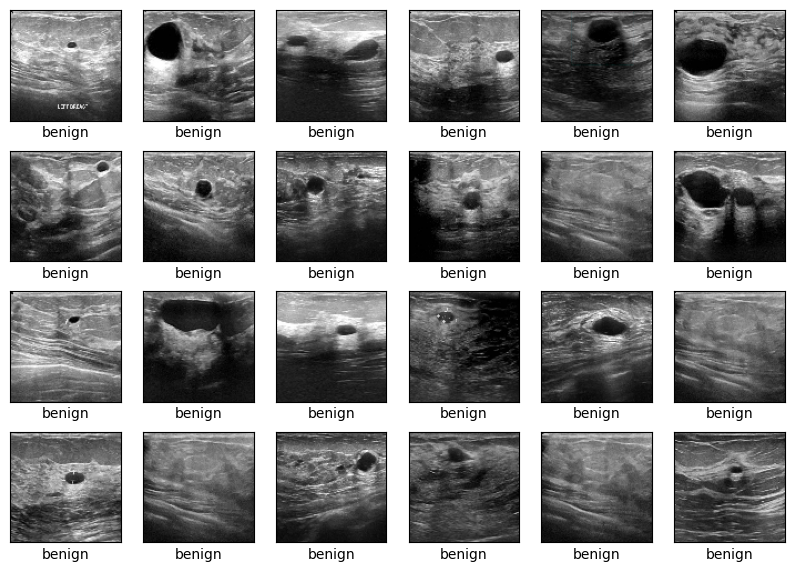

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6, figsize=(10, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=y[i])

In [52]:
X = X.reshape(len(X), -1)
y = y.reshape(len(X), -1)

X.shape, y.shape

((4680, 30000), (4680, 1))

# Split Data

In [53]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=10, 
                                                test_size=.20)

In [54]:
Xtrain.shape, Xtest.shape

((3744, 30000), (936, 30000))

# Feature Scalling

In [55]:
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

255 0
255 0


In [56]:
Xtrain = Xtrain/255
Xtest = Xtest/255
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

1.0 0.0
1.0 0.0


# Feature Selection

In [57]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
model = make_pipeline(pca, svc)

# Train Model

In [58]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50, 100, 200],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005, 0.01, 0.1]}
grid = GridSearchCV(model, param_grid, cv=5)

%time grid.fit(Xtrain, ytrain)

CPU times: total: 3h 34min 32s
Wall time: 2h 56min 17s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid={'svc__C': [1, 5, 10, 50, 100, 200],
                         'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005, 0.01,
                                        0.1]})

In [59]:
print(grid.best_params_)

{'svc__C': 100, 'svc__gamma': 0.01}


In [60]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

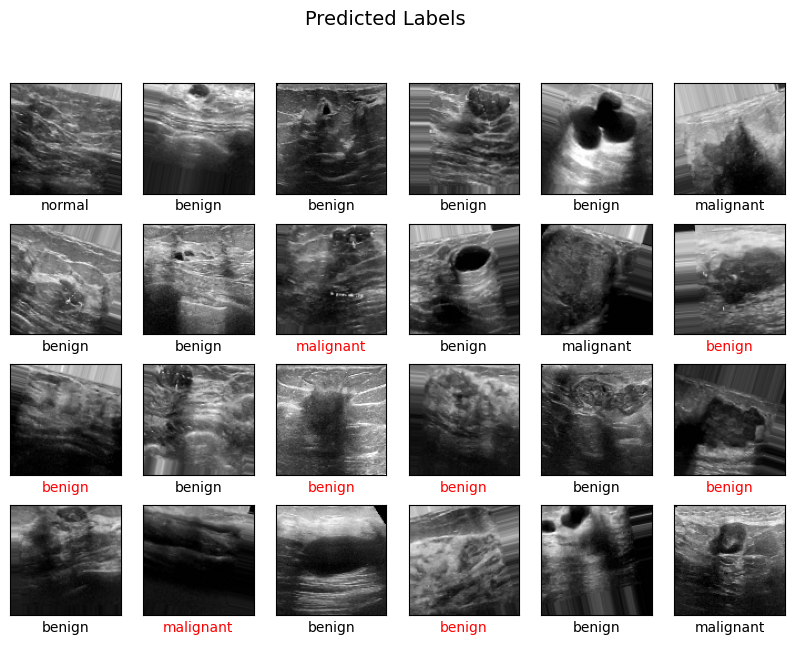

In [61]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [62]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 3744
Jumlah sampel data pengujian: 936


# Evaluation

In [63]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.70      0.84      0.76       521
   malignant       0.60      0.52      0.56       256
      normal       0.57      0.31      0.41       159

    accuracy                           0.66       936
   macro avg       0.62      0.56      0.58       936
weighted avg       0.65      0.66      0.65       936



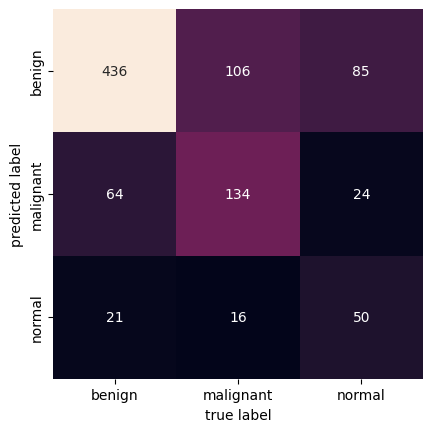

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [65]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.999465811965812
Testing Score: 0.6623931623931624


# K-FOLD CROSS VALIDATION

In [66]:
from sklearn.model_selection import cross_val_score
k_fold_acc = cross_val_score(model, Xtrain, ytrain, cv=10)
k_fold_mean = k_fold_acc.mean()

In [67]:
k_fold_acc

array([0.65333333, 0.69066667, 0.65066667, 0.66133333, 0.65775401,
       0.67379679, 0.64171123, 0.64171123, 0.68181818, 0.69251337])

In [68]:
k_fold_mean

0.6645304812834224

# Stratified KFold CrossVal

In [69]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for stratified k-fold cross-validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize an empty list to store the cross-validation scores
stratified_k_fold_acc = []

# Iterate over the stratified k-fold splits
for train_index, val_index in skf.split(Xtrain, ytrain):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = Xtrain[train_index], Xtrain[val_index]
    y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]

    # Fit the model on the training data for this fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation data for this fold
    fold_score = model.score(X_val_fold, y_val_fold)

    # Append the validation score to the list of cross-validation scores
    stratified_k_fold_acc.append(fold_score)

stratified_k_fold_acc

[0.6613333333333333,
 0.6613333333333333,
 0.6613333333333333,
 0.6426666666666667,
 0.6951871657754011,
 0.6951871657754011,
 0.6443850267379679,
 0.6844919786096256,
 0.6524064171122995,
 0.6229946524064172]

In [70]:
# Calculate the mean accuracy of stratified k-fold cross-validation
stratified_k_fold_mean = np.mean(stratified_k_fold_acc)
stratified_k_fold_mean

0.6621319073083779

# NEW QUERY

In [71]:
import joblib

# Menyimpan model ke dalam file
joblib.dump(model, 'UltraSound_SVM.model')

['UltraSound_SVM.model']

In [72]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Function to load and preprocess new query images from a specified folder
def load_and_preprocess_new_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (100, 100))  # Resize the image to match training data
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error occurred while processing image {img_path}: {e}")
    return images, labels

# Paths to new query images folders
new_query_benign_path = "C:/Users/Lenovo/Downloads/Benign (1)/Benign"  
new_query_malignant_path = "C:/Users/Lenovo/Downloads/Malignant/Malignant"

# Load and preprocess new query images from both folders
new_query_benign_images, new_query_benign_labels = load_and_preprocess_new_images_from_folder(new_query_benign_path, 'benign')
new_query_malignant_images, new_query_malignant_labels = load_and_preprocess_new_images_from_folder(new_query_malignant_path, 'malignant')

# Combine images and labels from both folders
new_query_images = new_query_benign_images + new_query_malignant_images
new_query_labels = new_query_benign_labels + new_query_malignant_labels

# Convert the list of images to a numpy array and preprocess them
X_new_query = np.array(new_query_images)
X_new_query = X_new_query.reshape(len(X_new_query), -1)  # Flatten images
X_new_query = X_new_query / 255  # Scale the pixel values

# Load the saved model
model = joblib.load('UltraSound_SVM.model')

# Predict using the trained model
y_new_query_pred = model.predict(X_new_query)

# Reshape the data back to the original shape for visualization
X_new_query_reshaped = X_new_query.reshape((X_new_query.shape[0], 100, 100, 3))

In [73]:
# Calculate and print accuracy
y_true = np.array(new_query_labels)
y_pred = y_new_query_pred

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on new query images: {accuracy:.2f}')

# Print classification report
print(classification_report(y_true, y_pred, target_names=['benign', 'malignant','normal']))

Accuracy on new query images: 0.62
              precision    recall  f1-score   support

      benign       0.58      0.80      0.67       109
   malignant       0.76      0.46      0.57       123
      normal       0.00      0.00      0.00         0

    accuracy                           0.62       232
   macro avg       0.45      0.42      0.41       232
weighted avg       0.67      0.62      0.62       232



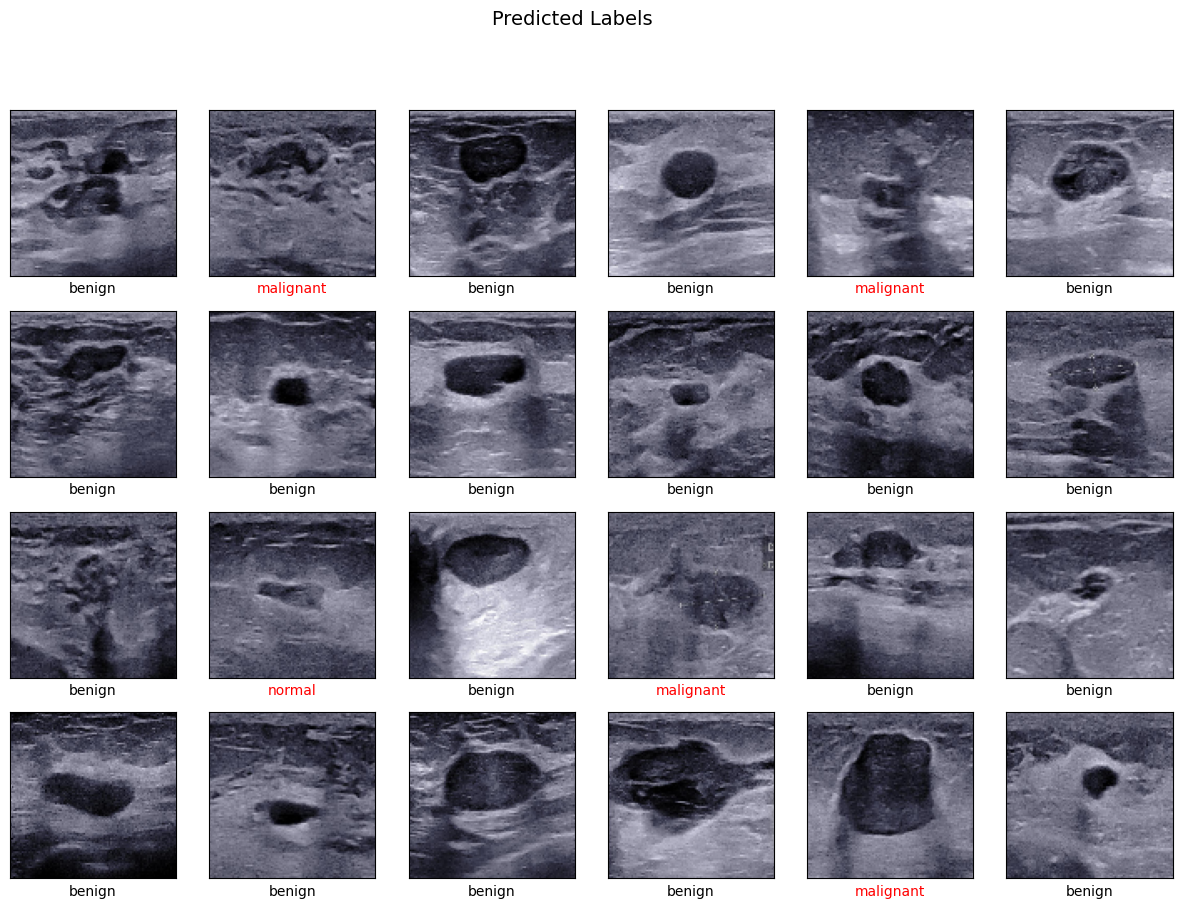

In [74]:
# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(15, 10))

for i, axi in enumerate(ax.flat):
    if i < len(new_query_images):
        axi.imshow(cv2.cvtColor(new_query_images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        color = 'black' if y_new_query_pred[i] == y_true[i] else 'red'
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(f'{y_new_query_pred[i]}', color=color)
    else:
        axi.axis('off')

fig.suptitle('Predicted Labels', size=14)
plt.show()

---